In [3]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.optimizers import Adam 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns
from keras.layers.core import Lambda
from keras import backend as K

Using Theano backend.


In [4]:
ds = Dataset.from_csv("bdata.2009.mhci.public.1.txt")
ds_h = ds.slice(ds.alleles == 'HLA-A0201')

In [5]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

def first_and_last_three(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:3],Y[-3+k:k]])
def first_and_last_four(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:4],Y[-4+k:k]])
def first_and_last_two(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:2],Y[-2+k:k]])
def cut_the_zeros(Y):
    k = np.count_nonzero(Y)
    return Y[:k]

X_44 = np.apply_along_axis(first_and_last_four,1,X)
X_33 = np.apply_along_axis(first_and_last_three,1,X)
X_22 = np.apply_along_axis(first_and_last_two,1,X)

nine_mers = np.array(list(df_h[df_h['peptide_length']==9]['index_encoded_peptides']))
X_9 = np.apply_along_axis(cut_the_zeros,1,nine_mers)
y_9 = np.array(list(df_h[df_h['peptide_length']==9]['log_meas']))


In [6]:
def regroup_together(affinities, weights , original_indices):
    affinities = affinities.ravel()
    weights = weights.ravel()
    
    assert affinities.shape == weights.shape, "%s should be %s" % (affinities.shape, weights.shape)
    assert affinities.shape == original_indices.shape
    assert len(affinities) == len(affinities.ravel())
    
    weighted_affinities = (affinities * weights)
    index_set = set(original_indices)
    n_indices = len(index_set)
    result_order = {original_index: i for (i, original_index) in enumerate(sorted(index_set))}
    result = np.zeros(n_indices)
    for i, x in enumerate(weighted_affinities):
        result_idx = result_order[original_indices[i]]
        result[result_idx] += x
    return result

def slicing(dataset, index, i):
    return dataset.slice(index).kmer_index_encoding()[i]

def label_transform(array):
    result = 1-np.log(array)/math.log(50000)
    result[result<0]=0
    return result

def index_to_hotshot_encoding(index_encoded_nine_mer):
    result = np.zeros((9,21))
    for position, amino_acid in enumerate(index_encoded_nine_mer):
        result[position][amino_acid]= 1
    return result.flatten()

def real_labels(dataset,index):
    
    y = label_transform(slicing(dataset,index,1))
    weights = slicing(dataset,index,2)
    original_indices = slicing(dataset,index,3)
    
    return regroup_together(y, weights , original_indices)

def fit(model,dataset,index, neural_network = False, hotshot = False): # to be left out or modified 
    
    X = slicing(dataset,index,0)
    
    if (hotshot == True):
        X = np.apply_along_axis(index_to_hotshot_encoding, 1, X)
        
    y = label_transform(slicing(dataset,index,1))
    weights = slicing(dataset,index,2)
    
    if (neural_network == True):
        model.fit(X, y, sample_weight = weights, batch_size = 16, nb_epoch = 1)
    else: 
        model.fit(X, y, sample_weight = weights)
        
def predict(model, dataset, index, hotshot = False):
    
    X = slicing(dataset,index,0)
    
    if (hotshot == True):
        X = np.apply_along_axis(index_to_hotshot_encoding, 1, X)
        
    weights = slicing(dataset,index,2)
    original_indices = slicing(dataset,index,3)
    
    return regroup_together(model.predict(X), weights , original_indices)

def AUC(model, dataset, index, hotshot = False):
        
    real_affinity = measured_affinity_less_than(real_labels(dataset,index),500)
    predicted_affinity = predict(model, dataset, index, hotshot = hotshot)
    
    return roc_auc_score(real_affinity, predicted_affinity)

def AUC_simple(model, features, labels, index):
    real_affinity = measured_affinity_less_than(labels[index],500)
    predicted_affinity = model.predict(features[index])
    
    return roc_auc_score(real_affinity, predicted_affinity)

def AUC_simple_average(model_1, model_2, features, labels, index):
    real_affinity = measured_affinity_less_than(labels[index],500)
    predicted_affinity_1 = model_1.predict(features[index])
    predicted_affinity_2 = model_2.predict(features[index])
    predicted_affinity = 0.5* predicted_affinity_1 + 0.5* predicted_affinity_2
    
    return roc_auc_score(real_affinity, predicted_affinity)

In [7]:
def split_by_length(X,index,length=9):
    length_idx = np.array([i for i in index if (np.count_nonzero(X[i])==length)])
    non_length_idx = np.array([i for i in index if (np.count_nonzero(X[i])!=length)])
    return index, length_idx, non_length_idx

In [8]:
from numpy import ma 

array_test = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
position = [[1,0,0,0], [0,1,0,0], [0,0,1,0]]
values = 0
mx = ma.masked_array(array_test, mask=position, fill_value =0)
print(mx)

[[-- 2 3 4]
 [5 -- 7 8]
 [9 10 -- 12]]


In [9]:
def sum_character_deletion(model,array,length): 
    result = np.zeros(len(array))
    for i in range(length):
        position_matrix = np.zeros((len(array),length))
        position_matrix[:,i] = 1 
        mx = ma.masked_array(array, mask=position_matrix)
        result = result + model.predict(mx)
        
    return result / length
        
def random_dropout_prediction_by_lentgh(model,array,length):
    array_of_lengths = np.apply_along_axis(np.count_nonzero,1,array)
    #print("array shape", array.shape, "array of lengths shape", array_of_lengths.shape)
    bool_array = (array_of_lengths == length)
    #print("bool_array shape", bool_array.shape)
    result = np.zeros(len(array))
    #print("result shape", result.shape)
    for i in range(length):
        position_matrix = np.zeros(array.shape)
        position_matrix[:,i] = 1 
        print("array shape", array.shape, "position_matrix shape", position_matrix.shape)
        mx = ma.masked_array(array, mask=position_matrix)
        result[bool_array] = result[bool_array] + model.predict(mx)
    
    #print("result[bool_array] shape", result[bool_array].shape, "model prediction shape", model.predict(array[bool_array]).shape)
    return result/length

def random_dropout_array_prediction(model,array):
    array_of_lengths = np.apply_along_axis(np.count_nonzero,1,array)
    result = np.zeros(len(array))
    for length in np.unique(array_of_lengths):
        result = result + random_dropout_prediction_by_lentgh(model,array,length)
    return result

def AUC_random_dropout(model, features, labels, index):
    real_affinity = measured_affinity_less_than(labels[index],500)
    predicted_affinity = random_dropout_array_prediction(model, features[index])
    
    return roc_auc_score(real_affinity, predicted_affinity)

In [10]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 70
epoch = 0



nn_aucs = np.zeros((2, folds,n_epochs))
lstm_aucs = np.zeros((2, folds,n_epochs))
average_aucs = np.zeros((2, folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(X_9),folds, shuffle=True)):
    
    list_index = split_by_length(X,train_idx,length=9)+split_by_length(X,test_idx,length=9)
    
    
    # lstm_avg 
    nn = Sequential()
    nn.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    nn.add(Flatten())
    nn.add(Dense(10, init='glorot_uniform', activation='tanh'))
    nn.add(Dropout(dropout_probability))
    nn.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    nn.compile(optimizer = 'adam', loss='mean_squared_error')
    
    # lstm 
    sequence = Input( shape= (9, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 9, output_dim= 32)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    adam = Adam(lr=0.01)
    lstm.compile(optimizer = adam, loss='mean_squared_error')
      
    
    for epoch in range(n_epochs):
        
        
        #nn
        nn.fit(X_9[train_idx],y_9[train_idx], batch_size = 16, nb_epoch = 1)
        for k, index in enumerate([train_idx,test_idx]):
            nn_aucs[k][i][epoch] = AUC_simple(nn, X_9, y_9, index)
            
        #deep_nn
        adam.lr.set_value(0.01*(epoch+1)**(-2))
        lstm.fit(X_9[train_idx],y_9[train_idx], batch_size = 16, nb_epoch = 1)
        for k, index in enumerate([train_idx,test_idx]):
            lstm_aucs[k][i][epoch] = AUC_simple(lstm, X_9, y_9, index)
            
        for k, index in enumerate([train_idx,test_idx]):
            average_aucs[k][i][epoch] = AUC_simple_average(lstm,nn, X_9, y_9, index)    
        
        print("AUC:", nn_aucs[1][i][epoch], lstm_aucs[1][i][epoch], average_aucs[1][i][epoch], i, epoch)  

Epoch 1/1
4640/4640 [==============================] - 0s - loss: 0.0703     
Epoch 1/1
4640/4640 [==============================] - 3s - loss: 0.0523     
AUC: 0.943159568618 0.931597437487 0.945975670838 0 0
Epoch 1/1
4640/4640 [==============================] - 0s - loss: 0.0315     
Epoch 1/1
4640/4640 [==============================] - 2s - loss: 0.0308     
AUC: 0.957077208136 0.9480273274 0.955916967016 0 1
Epoch 1/1
4640/4640 [==============================] - 0s - loss: 0.0282     
Epoch 1/1
4640/4640 [==============================] - 2s - loss: 0.0271     
AUC: 0.958826764179 0.951898592299 0.95834077639 0 2
Epoch 1/1
4640/4640 [==============================] - 0s - loss: 0.0269     
Epoch 1/1
4640/4640 [==============================] - 3s - loss: 0.0254     
AUC: 0.960123607273 0.953517675945 0.959947600884 0 3
Epoch 1/1
4640/4640 [==============================] - 0s - loss: 0.0266     
Epoch 1/1
4640/4640 [==============================] - 4s - loss: 0.0247     
AUC: 0.

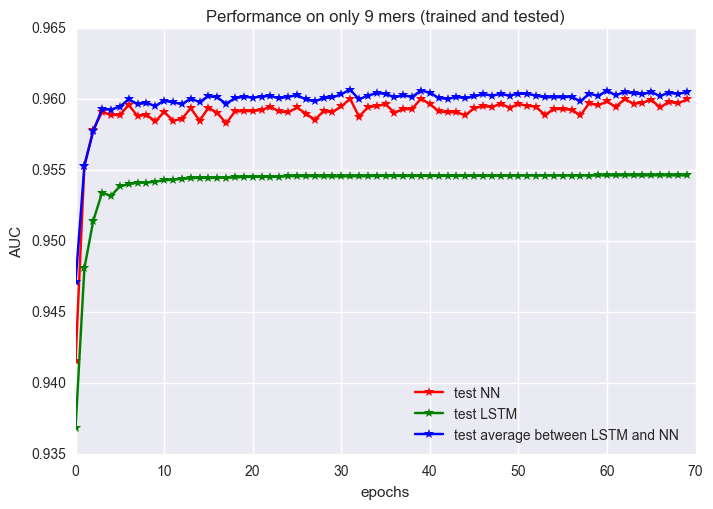

In [11]:
plt.plot( np.arange(0,n_epochs,1), nn_aucs[1,:,:].mean(axis=0),color='r',marker='*', linestyle='-', label ="test NN ")
plt.plot( np.arange(0,n_epochs,1), lstm_aucs[1,:,:].mean(axis=0),color='g',marker='*', linestyle='-', label ="test LSTM ")
plt.plot( np.arange(0,n_epochs,1), average_aucs[1,:,:].mean(axis=0),color='b',marker='*', linestyle='-', label ="test average between LSTM and NN ")


plt.xlabel('epochs')
plt.ylabel('AUC')
plt.title('Performance on only 9 mers (trained and tested)')
plt.legend(loc=4)

In [12]:
(lstm.predict(X_9[test_idx])-y_9)**2

array([[  3.07729041e-04,   5.12093015e-02,   4.10390438e-01, ...,
          3.47655523e-01,   3.47655523e-01,   3.47655523e-01],
       [  1.24147164e-01,   2.06188689e-02,   7.32946195e-02, ...,
          4.82838053e-02,   4.82838053e-02,   4.82838053e-02],
       [  2.50410836e-01,   8.50644775e-02,   1.50465447e-02, ...,
          5.13663614e-03,   5.13663614e-03,   5.13663614e-03],
       ..., 
       [  3.06160380e-01,   1.18725106e-01,   4.86609658e-03, ...,
          3.52064588e-04,   3.52064588e-04,   3.52064588e-04],
       [  4.06454074e-01,   1.83856570e-01,   2.09163413e-04, ...,
          4.28455484e-03,   4.28455484e-03,   4.28455484e-03],
       [  2.70998618e-01,   9.72334341e-02,   1.05061985e-02, ...,
          2.65283926e-03,   2.65283926e-03,   2.65283926e-03]])

In [13]:
(nn.predict(X_9[test_idx])-y_9)**2

array([[  2.98086000e-02,   1.45469154e-01,   6.33180977e-01, ...,
          5.54626748e-01,   5.54626748e-01,   5.54626748e-01],
       [  1.41928525e-01,   2.82177873e-02,   6.06838885e-02, ...,
          3.81604396e-02,   3.81604396e-02,   3.81604396e-02],
       [  2.59690661e-01,   9.05083241e-02,   1.28769150e-02, ...,
          3.90405872e-03,   3.90405872e-03,   3.90405872e-03],
       ..., 
       [  3.25452364e-01,   1.30849901e-01,   2.76578183e-03, ...,
          2.54936415e-06,   2.54936415e-06,   2.54936415e-06],
       [  3.55996885e-01,   1.50468140e-01,   6.98031173e-04, ...,
          6.03869118e-04,   6.03869118e-04,   6.03869118e-04],
       [  3.04669231e-01,   1.17797216e-01,   5.05613701e-03, ...,
          4.04512280e-04,   4.04512280e-04,   4.04512280e-04]])

In [14]:
deviation_array = (lstm.predict(X_9[test_idx])[:,0]-y_9[test_idx])**2 - (nn.predict(X_9[test_idx])[:,0]-y_9[test_idx])**2
lstm_error = (lstm.predict(X_9[test_idx])[:,0]-y_9[test_idx])**2
nn_error = (nn.predict(X_9[test_idx])[:,0]-y_9[test_idx])**2

m = deviation_array.mean()
std = deviation_array.std()

lstm_error_mean = lstm_error.mean()
nn_error_mean = nn_error.mean()
lstm_error_std = lstm_error.std()
nn_error_std = nn_error.std()

In [15]:
(deviation_array > 0.01 ).sum()

460

In [16]:
len(deviation_array)

2320

In [17]:
lstm_error_mean

0.028884873148310553

In [18]:
lstm_error_std

0.052393590487538604

In [19]:
(lstm_error > 0.1).sum()

172

In [20]:
nn_error_mean, nn_error_std

(0.025533444676375493, 0.047269560703641321)

In [21]:
(nn_error > 0.1).sum()

129

In [22]:
np.histogram(lstm_error)

(array([1958,  217,   79,   33,   10,   11,    6,    2,    2,    2]),
 array([  6.31833016e-08,   5.48203014e-02,   1.09640540e-01,
          1.64460778e-01,   2.19281016e-01,   2.74101254e-01,
          3.28921492e-01,   3.83741731e-01,   4.38561969e-01,
          4.93382207e-01,   5.48202445e-01]))

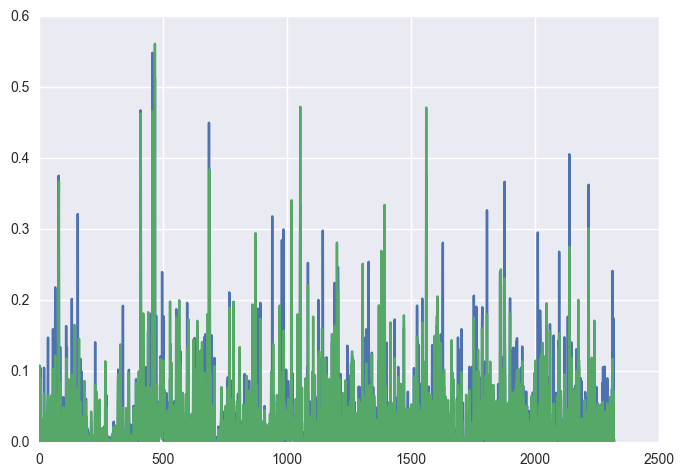

In [23]:
plt.plot(lstm_error)
plt.plot(nn_error)

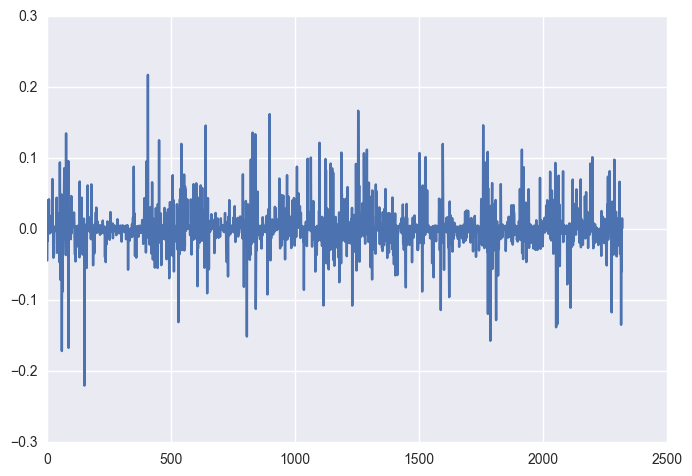

In [51]:
plt.plot(deviation_array)

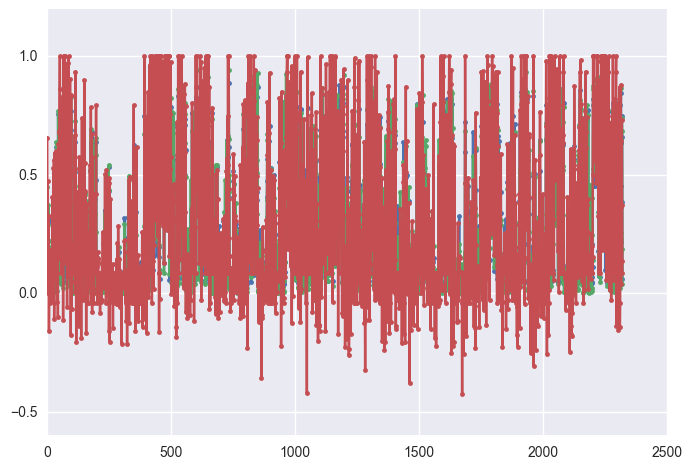

In [62]:
plt.plot(nn.predict(X_9[test_idx]), marker='.')
plt.plot(lstm.predict(X_9[test_idx]), marker='.')
plt.plot(y_9[test_idx], marker='.')

In [84]:
t=0.001
lstm_small = (lstm_error < t)
lstm_large = (lstm_error >= t)
nn_small = (nn_error < t)
nn_large = (nn_error >= t)

A = nn_large & lstm_large 
B = nn_large & lstm_small
C = nn_small & lstm_large
D = nn_small & lstm_small

A.sum(), B.sum(), C.sum(), D.sum()

(1765, 145, 252, 158)

In [81]:
A = nn_large & lstm_large 
B = nn_large & lstm_small
C = nn_small & lstm_large
D = nn_small & lstm_small

In [82]:
A.sum(), B.sum(), C.sum(), D.sum()

(1033, 234, 424, 629)

In [80]:
len(A)

2320

In [86]:
X_9[test_idx][C]

array([[ 1,  1,  6, ...,  8,  5, 18],
       [ 1,  1,  8, ..., 18, 16, 18],
       [ 1,  1,  8, ...,  1, 18,  1],
       ..., 
       [20, 18,  3, ..., 15,  3, 20],
       [20, 18,  3, ...,  9, 17, 10],
       [20, 20,  9, ..., 16, 20,  5]])

In [87]:
X_9[test_idx][B]

array([[ 1,  1,  6, ...,  2, 17, 11],
       [ 1,  5, 16, ...,  6, 18, 18],
       [ 1,  8,  8, ...,  1, 20,  1],
       ..., 
       [20, 17,  1, ..., 10, 18, 20],
       [20, 18,  8, ..., 13, 15,  8],
       [20, 18, 10, ...,  8, 18, 18]])

In [97]:
lstm.get_config()

{'input_layers': [['input_4', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 9),
    'input_dtype': 'int32',
    'name': 'input_4',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_4'},
  {'class_name': 'Embedding',
   'config': {'W_constraint': None,
    'W_regularizer': None,
    'activity_regularizer': None,
    'batch_input_shape': (None, 9),
    'dropout': 0.0,
    'init': 'uniform',
    'input_dim': 21,
    'input_dtype': 'int32',
    'input_length': 9,
    'mask_zero': False,
    'name': 'embedding_8',
    'output_dim': 32,
    'trainable': True},
   'inbound_nodes': [[['input_4', 0, 0]]],
   'name': 'embedding_8'},
  {'class_name': 'LSTM',
   'config': {'U_regularizer': None,
    'W_regularizer': None,
    'activation': 'tanh',
    'b_regularizer': None,
    'consume_less': 'cpu',
    'dropout_U': 0.0,
    'dropout_W': 0.0,
    'forget_bias_init': 'one',
    'go_backwards': False,
    'init': 'glorot_uniform',
    'inne

In [101]:
lstm.layers[2].get_config()

{'U_regularizer': None,
 'W_regularizer': None,
 'activation': 'tanh',
 'b_regularizer': None,
 'consume_less': 'cpu',
 'dropout_U': 0.0,
 'dropout_W': 0.0,
 'forget_bias_init': 'one',
 'go_backwards': False,
 'init': 'glorot_uniform',
 'inner_activation': 'hard_sigmoid',
 'inner_init': 'orthogonal',
 'input_dim': 32,
 'input_length': None,
 'name': 'lstm_7',
 'output_dim': 50,
 'return_sequences': False,
 'stateful': False,
 'trainable': True,
 'unroll': False}

In [132]:
len(lstm.layers[2].get_weights()[11])

50

In [154]:
len(lstm.layers[2].get_weights()[0][31])

50

In [156]:
nn.get_config()

[{'class_name': 'Embedding',
  'config': {'W_constraint': None,
   'W_regularizer': None,
   'activity_regularizer': None,
   'batch_input_shape': (None, 9),
   'dropout': 0.0,
   'init': 'uniform',
   'input_dim': 21,
   'input_dtype': 'int32',
   'input_length': 9,
   'mask_zero': False,
   'name': 'embedding_7',
   'output_dim': 32,
   'trainable': True}},
 {'class_name': 'Flatten', 'config': {'name': 'flatten_4', 'trainable': True}},
 {'class_name': 'Dense',
  'config': {'W_constraint': None,
   'W_regularizer': None,
   'activation': 'tanh',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'bias': True,
   'init': 'glorot_uniform',
   'input_dim': None,
   'name': 'dense_10',
   'output_dim': 10,
   'trainable': True}},
 {'class_name': 'Dropout',
  'config': {'name': 'dropout_7', 'p': 0.25, 'trainable': True}},
 {'class_name': 'Dense',
  'config': {'W_constraint': None,
   'W_regularizer': None,
   'activation': 'sigmoid',
   'activity_regular

In [170]:
len(nn.layers[4].get_weights())

2

In [183]:
len(nn.layers[0].get_weights()[0][0])

32

In [184]:
from keras import backend as K

# with a Sequential model
get_flatten_layer_output = K.function([nn.layers[0].input],
                                  [nn.layers[1].output])
layer_output = get_flatten_layer_output([X_9[test_idx]])[0]

In [187]:
len(layer_output[0])

288

In [188]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
pca.fit(layer_output)
embedding_vectors_lstm_pca = pca.transform(layer_output)

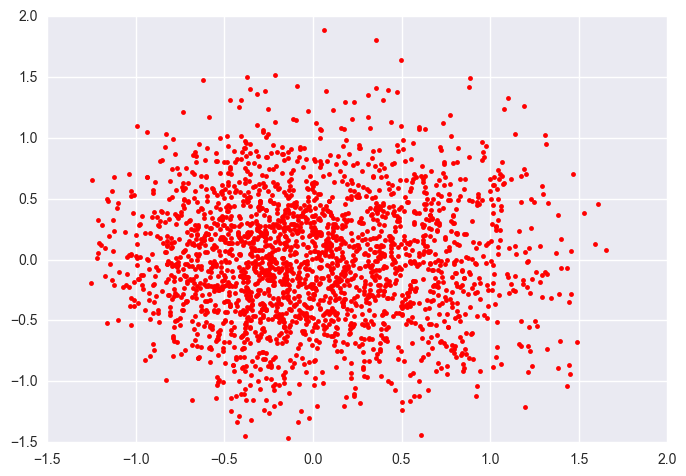

In [193]:
plt.plot(embedding_vectors_lstm_pca[1:,0],embedding_vectors_lstm_pca[1:,1], linestyle='',color= 'r', marker='.')

In [190]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
embedding_vectors_lstm_tsne = tsne.fit_transform(layer_output)

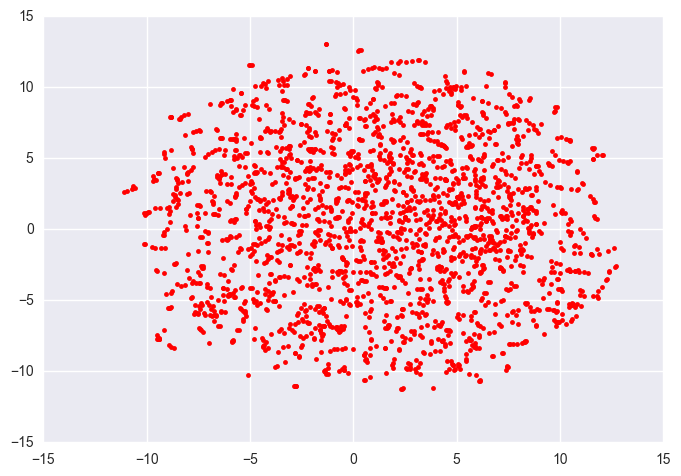

In [199]:
plt.plot(embedding_vectors_lstm_tsne[1:,0],embedding_vectors_lstm_tsne[1:,1], linestyle='',color= 'r', marker='.' )


In [1]:
print(3)

3


In [2]:
X_9

NameError: name 'X_9' is not defined